## Imports

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

## Parameters

In [14]:
# label/sheet name : total_row_switch, row offset, index columns
output_dict = {
    "Mapping" : [False, -4, 0],
    "Demand" : [True, 0, 0],
    "Production" : [True, 0, 0],
    "Price" : [False, 0, 0],
    "LNG" : [True, 8, [0, 1, 2]],
    "Piped Imports" : [True, 12, [0, 1, 2]],
    "Connections" : [False, 12, [0, 1, 2]],
    "Supply Mix" : [False, 10, [0, 1]]
}

output_df_dict = {}

# Border color
edgecolor = "black"
# Color scheme
cmap = "cool"
# Line width
linewidth = 1

In [3]:
country_names = {
    "Deutschland" : "Germany",
    "Niederlande" : "Netherlands",
    "Frankreich" : "France",
    "Schweiz" : "Switzerland",
    "Luxemburg" : "Luxembourg"
}

## Data from Excel

In [16]:
for output_metric, output_params in output_dict.items():
    output_df_dict[output_metric] = pd.read_excel(
        io = "../gasmarketmodel/data/outputs/Master.xlsx",
        sheet_name = output_metric,
        skiprows = 4 + output_params[1],
        index_col = output_params[2]
    )
    # Drop Total row
    if output_params[0]:
        output_df_dict[output_metric].drop("Total", inplace = True)

/home/flo/.pyenv/versions/3.8.6/envs/gasmarketmodel/lib/python3.8/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


## Map Data

### Blank Map

In [17]:
output_df_dict["Mapping"]

,Region
E,Deutschland
E,Frankreich
Benelux,Niederlande
Schweiz,Schweiz
Benelux,Luxemburg
Benelux,Benelux


In [18]:
country_map = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres")).explode(index_parts = True).merge(
    pd.DataFrame.from_dict(
        country_names,
        orient = "index",
        columns = ["c_name"]
    ).reset_index(),
    left_on = "name",
    right_on = "c_name",
)[["index", "geometry"]].set_index("index")
country_map["area"] = country_map["geometry"].area
print(country_map)
country_map = country_map.sort_values("area", ascending = False).groupby("index").first()
print(country_map)
country_map = country_map.merge(
    output_df_dict["Mapping"],
    left_index = True,
    right_on = ["Region"]
).reset_index().dissolve(by = "index").drop(columns = ["Region", "area"])
print(country_map)
country_map["labelpoint"] = country_map["geometry"].apply(lambda x: x.representative_point().coords[:][0])
country_map



                                                      geometry       area
index                                                                    
Frankreich   POLYGON ((-51.65780 4.15623, -52.24934 3.24109...   6.941855
Frankreich   POLYGON ((6.18632 49.46380, 6.65823 49.20196, ...  64.627290
Frankreich   POLYGON ((8.74601 42.62812, 9.39000 43.00998, ...   1.046521
Deutschland  POLYGON ((14.11969 53.75703, 14.35332 53.24817...  45.923594
Schweiz      POLYGON ((9.59423 47.52506, 9.63293 47.34760, ...   5.440201
Luxemburg    POLYGON ((6.04307 50.12805, 6.24275 49.90223, ...   0.301516
Niederlande  POLYGON ((6.90514 53.48216, 7.09205 53.14404, ...   5.264180
                                                      geometry       area
index                                                                    
Deutschland  POLYGON ((14.11969 53.75703, 14.35332 53.24817...  45.923594
Frankreich   POLYGON ((6.18632 49.46380, 6.65823 49.20196, ...  64.627290
Luxemburg    POLYGON ((6.04307 50.1280

/tmp/ipykernel_19929/327683483.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  country_map["area"] = country_map["geometry"].area


,geometry,labelpoint
index,,
Benelux,"MULTIPOLYGON (((6.24275 49.90223, 6.18632 49.4...","(5.398113217342898, 52.04023468689047)"
E,"POLYGON ((7.19220 47.44977, 6.73657 47.54180, ...","(5.905536090604743, 48.664290879910766)"
Schweiz,"POLYGON ((9.59423 47.52506, 9.63293 47.34760, ...","(8.28651553630333, 46.80966248227965)"


### Demand

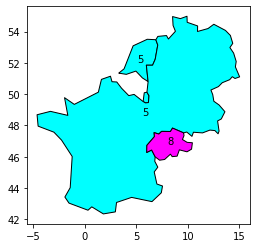

In [19]:
demand_map = country_map.merge(
    output_df_dict["Demand"],
    left_index = True,
    right_index = True
)
demand_map.plot(
    column = "Aug-21",
    cmap = cmap,
    edgecolor = edgecolor,
    linewidth = linewidth
)
for idx, row in demand_map.iterrows():
    plt.annotate(text = row["Aug-21"],
                 xy = row["labelpoint"],
                 horizontalalignment = "center"
                )

### Prices

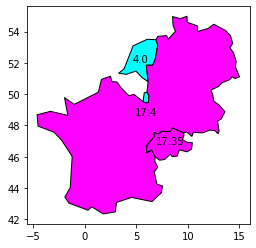

In [20]:
price_map = country_map.merge(
    output_df_dict["Price"],
    left_index = True,
    right_index = True
)
price_map.plot(
    column = "Aug-21",
    cmap = cmap,
    edgecolor = edgecolor,
    linewidth = linewidth
)
for idx, row in price_map.iterrows():
    plt.annotate(text = round(row["Aug-21"],2),
                 xy = row["labelpoint"],
                 horizontalalignment = "center"
                )

In [9]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
list(world[world["name"] == "France"].geometry.values[0])

/tmp/ipykernel_19929/652287095.py:2: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  list(world[world["name"] == "France"].geometry.values[0])
/tmp/ipykernel_19929/652287095.py:2: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  list(world[world["name"] == "France"].geometry.values[0])
